# Logistic Regression for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [29]:
import re
import collections
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [30]:
# if you want to download the original file:
#df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


Let us shuffle the class labels.

In [31]:
df.head().values[0]

array(['In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and ric

In [32]:
## uncomment these lines if you have dowloaded the original file:
#np.random.seed(0)
#df = df.reindex(np.random.permutation(df.index))
#df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)

<br>
<br>

## Preprocessing Text Data

Now, let us define a simple `tokenizer` that splits the text into individual word tokens. Furthermore, we will use some simple regular expression to remove HTML markup and all non-letter characters but "emoticons," convert the text to lower case, remove stopwords, and apply the Porter stemming algorithm to convert the words into their root form.

In [33]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
#stop = stopwords.words('english')
#porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower())
    text = [w for w in text.split()]
    tokenized = [wordnet_lemmatizer.lemmatize(w) for w in text]
    return tokenized

Let's give it at try:

In [34]:
tokenizer('This :) is a <a> test! :-)</br>')


['this', 'is', 'a', 'test']

## Learning (SciKit)

First, we define a generator that returns the document body and the corresponding class label:

In [35]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To conform that the `stream_docs` function fetches the documents as intended, let us execute the following code snippet before we implement the `get_minibatch` function:

In [36]:
#next(stream_docs(path='shuffled_movie_data.csv'))

After we confirmed that our `stream_docs` functions works, we will now implement a `get_minibatch` function to fetch a specified number (`size`) of documents:

In [37]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

Next, we will make use of the "hashing trick" through scikit-learns [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) to create a bag-of-words model of our documents. Details of the bag-of-words model for document classification can be found at  [Naive Bayes and Text Classification I - Introduction and Theory](http://arxiv.org/abs/1410.5329).

In [38]:
# Exercise 1: define features based on word embeddings (pre-trained word2vec / Glove/Fastext emebddings can be used)
# Define suitable d dimension, and sequence length

## Word Embedding

In [39]:
doc_generator = stream_docs(path='shuffled_movie_data.csv')

In [40]:
def bag_words(gen, size):
    bag    = []
    for i, doc in enumerate(gen):
        bag += tokenizer(doc[0])
        sys.stdout.write('\r{:5.2f}%'.format(100*(i+1)/50000))
    sys.stdout.write('\rDone     \n\n')
    print('Bag Size: ', len(bag))
    count  = [['UNK', -1]]
    count += collections.Counter(bag).most_common(size - 1)
    
    count  = [(word, cnt) for word, cnt in count if cnt not in [0,1]]
    for element in count:
        if element[1] == 1:
            count.remove(element)
    dic    = {}
    for i, word in enumerate(count):
        dic[word[0]] = i
    
    return dic , dict(zip(dic.values(), dic.keys()))

In [41]:
dic, rev_dic = bag_words(doc_generator, 80000) #63069

Done     

Bag Size:  11772191


In [42]:
FEATURES = len(dic.keys())

In [43]:
print(FEATURES)

56325


In [44]:
class OneHotEncoder:
    def __init__ (self, rev_dict):
        self.size = len(rev_dict.values())
        self.dict = rev_dict
        
    def __repr__ (self):
        return ('OneHotEncoder Class (Size = {})'.format(self.n))
        
    def getVector(self, word):
        vec = np.zeros((1, self.size))
        vec[0, self.dict[word]] = 1
        return vec

In [45]:
class DocToVec:
    """
        Convert a list of words to feature vectors:
        
        Arguments:
            
            n_features: number of features per vector, by default 6818.
            fn        : tokenizer function
    """
    
    def __init__(self, dictionary, tokenizer):
        self.encoder  = OneHotEncoder(dic) 
        self.dict     = dictionary
        self.features = self.encoder.size
        self.fn       = tokenizer
        
    def transform(self, DocList):
        """
            Transform an array of list of words to a matrix:

            Arguments:

                DocList: Array of list of reviews

            Returns:

                Matrix with feature vectors of each review.

        """
    
        n   = len(DocList)
        vec = np.zeros(shape=(n, self.features), dtype = np.uint8)
        
        total_time = 0
        for idx, strn in enumerate(DocList):
            start_time = time.time()
            rev_tok    = self.fn(strn)
            veci = np.zeros((1, self.features))
            for word in rev_tok:
                if word in self.dict:
                    veci += self.encoder.getVector(word)
            vec[idx] = veci
            if ((idx+1) % 500 == 0):
                elapsed  = time.time() - start_time
                total_time += elapsed
                total_time /= (idx+1/500)
                print('percent = {:4.1f}%, time estimated : {:3.1f} min'.format(100*(idx+1)/n, n*elapsed/60.0))
        return vec       

In [46]:
encoder = DocToVec(dic, tokenizer)

In [47]:
l = encoder.transform([df.head().values[0][0]])

FirstReview = []
for i in range(FEATURES):
    if l[0][i] != 0:
        FirstReview.append((rev_dic[i], int(l[0][i])))

FirstReview.sort(key=lambda x: x[1])

FirstReview = FirstReview[::-1]
for i in range(10):
    print('{:20} : {:3} times'.format(FirstReview[i][0], FirstReview[i][1]))

the                  :  23 times
of                   :  12 times
in                   :  10 times
a                    :  10 times
and                  :   8 times
wa                   :   6 times
to                   :   6 times
murder               :   5 times
with                 :   4 times
is                   :   4 times


In [48]:
# Uncomment these lines if you don't save 'vec_data_X' and 'vec_data_y':
stream = stream_docs(path='shuffled_movie_data.csv')

X_train, y_train = get_minibatch(stream, size=50000)
y_train = np.asarray(y_train).reshape((-1, 1))

X_train = encoder.transform(X_train)

np.save('vec_data_X', X_train)
np.save('vec_data_y', y_train)

del X_train
del y_train
del stream

percent =  1.0%, time estimated : 22.5 min
percent =  2.0%, time estimated : 7.6 min
percent =  3.0%, time estimated : 3.5 min
percent =  4.0%, time estimated : 4.9 min
percent =  5.0%, time estimated : 16.4 min
percent =  6.0%, time estimated : 11.2 min
percent =  7.0%, time estimated : 3.4 min
percent =  8.0%, time estimated : 6.6 min
percent =  9.0%, time estimated : 7.1 min
percent = 10.0%, time estimated : 5.3 min
percent = 11.0%, time estimated : 15.8 min
percent = 12.0%, time estimated : 7.2 min
percent = 13.0%, time estimated : 2.0 min
percent = 14.0%, time estimated : 5.9 min
percent = 15.0%, time estimated : 11.1 min
percent = 16.0%, time estimated : 16.3 min
percent = 17.0%, time estimated : 9.6 min
percent = 18.0%, time estimated : 7.5 min
percent = 19.0%, time estimated : 37.1 min
percent = 20.0%, time estimated : 2.2 min
percent = 21.0%, time estimated : 11.3 min
percent = 22.0%, time estimated : 3.1 min
percent = 23.0%, time estimated : 18.4 min
percent = 24.0%, time est

In [49]:
X_train = np.load('vec_data_X.npy')
y_train = np.load('vec_data_y.npy')

In [50]:
from sklearn.preprocessing import normalize

print(X_train.shape)
print(y_train.shape)

(50000, 56325)
(50000, 1)


I think that the predictive performance, an accuracy of ~87%, is quite "reasonable" given that we "only" used the default parameters and didn't do any hyperparameter optimization. 

After we estimated the model perfomance, let us use those last 5,000 test samples to update our model.

In [ ]:
# Exercise 2: Define at least a Three layer neural network. Define its structure (number of hidden neurons, etc)
# Define a nonlinear function for hidden layers.
# Define a suitable loss function for binary classification
# Implement the backpropagation algorithm for this structure
# Do not use Keras / Tensorflow /PyTorch etc. libraries
# Train the model using SGD

## Multilayer Neural Network

We are using 3 layers, 2 hidden layers with tangent hiperbolic activation and a sigmoid function at the end. This neural network also work with L1 and L2 regularization.

We try to use few neurons on hidden layers to get a better generalization.

In [51]:
class Multilayer:
    """
        Logistic Regression with L1 and L2 regularization
        
        Arguments:
                
                alpha   : Learning Rate
                l1_coef : Lambda 1
                l2_coef : Lambda 2
            
    """
    
    def __init__ (self, input_size, hid_units1, hid_units2, lr, lambda_1, lambda_2):
        self.W1      = np.random.randn(input_size, hid_units1) * np.sqrt(1/input_size)
        self.b1      = np.zeros((1, hid_units1))
        self.W2      = np.random.randn(hid_units1, hid_units2) * np.sqrt(1/hid_units1)
        self.b2      = np.zeros((1, hid_units2))
        self.W3      = np.random.randn(hid_units2,          1) * np.sqrt(1/hid_units2)
        self.b3      = 0.0
        self.lr      = lr
        self.l1_coef = lambda_1
        self.l2_coef = lambda_2
        
    def ReLU(self, z):
        return np.maximum(0, z)
    
    def TangH(self, z):
        return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z) + 1e-8)
    
    def deltaTangH(self, z):
        return 4 * np.exp(z) * np.exp(-z)/(np.exp(z) + np.exp(-z)+ 1e-8)**2
    
    def sigmoid(self,z):
        """
            Activation function
            
            Arguments:  
                z : W*X + b
                
            Returns:
                sigmoid function of z.
                
        """
        return 1 / (1 + np.exp(-z))
    
    def deltaCost(self, y, y_hat):
        return y_hat - y
        
    def pred(self, X):
        """
            Given a X matrix as a input we return the prediction for
            W and b.
            
            Args:
                X : Matrix of features vectors for each review
            
            Returns:
                Prediction without a threshold
        """
        Z1 = np.dot(X , self.W1) + self.b1
        A1 = self.TangH(Z1)
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self.TangH(Z2)   
        Z3 = np.dot(A2, self.W3) + self.b3
        A3 = self.sigmoid(Z3)          
        return A3

    def predSentiment(self, X):
        """
            Given a X matrix as a input we return the prediction with threshold 
            for W and b.
            
            Args:
                X : Matrix of features vectors for each review
            
            Returns:
                Prediction with threshold
        """
        return self.pred(X) > 0.5
    
    def acc(self, X, y):
        """
            Accuracy of a input and label
            
            Args:
                X: Matrix of features vectors for each review
                y: Labels of each Matrix
            
            Returns:
                A number between 0 and 1.0
        """
        
        return np.mean(self.predSentiment(X) == y)
    
    def getCost(self,y, y_hat):
        """
            Cost function
            
                Cost = - [y * log(sigma(W*X + b)) + (1 - y) * log(1 - sigma(W*X + b))] 
                         + 0.5 * l2_ratio * ||w||^2_2 
                         + l1_ratio * ||w||_1 
            
            Args:
                X: Matrix of features vectors for each review
                y: Labels of each Matrix
                
            Returns:
                Cost using L1 and L2 regularizations 
                
        """
        y_hat = np.clip(y_hat, 1e-8, 1 - 1e-8)
        cost  = - 0.5 * np.mean(np.multiply(y  , np.log(y_hat     + 1e-5))
                             + np.multiply(1-y , np.log(1 - y_hat + 1e-5)))
        
        cost += 0.5 * self.l2_coef * np.sum(np.square(self.W1)) + self.l1_coef * np.sum(np.abs(self.W1)) 
        cost += 0.5 * self.l2_coef * np.sum(np.square(self.W2)) + self.l1_coef * np.sum(np.abs(self.W2))
        
        return cost 
    
    def Propagation(self, X, y):
        # Forward Propagation
        
        Z1 = np.dot(X , self.W1) + self.b1
        A1 = self.TangH(Z1)
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self.TangH(Z2)
        Z3 = np.dot(A2, self.W3) + self.b3
        A3 = self.sigmoid(Z3)
        cost   = self.getCost(y, A3)        
        d_cost = self.deltaCost(y, A3)
        
        # Backward Propagation
        
        dW3     = np.dot(A2.T, d_cost)
        db3     = np.sum(d_cost, axis=0, keepdims=True) 
        
        # Hidden Layer 2
        dhidden2 = np.dot(d_cost, self.W3.T)
        
        # The TangH derivative
        dG2 = self.deltaTangH(Z2)
        #dhidden[A1 <= 0] = 0
        assert(dG2.shape == dhidden2.shape)
        dhidden2 = dG2 * dhidden2
        # Second Layer
        dW2  = np.matmul(A1.T, dhidden2)
        db2  = np.sum(dhidden2, axis=0, keepdims=True)        
    
        # Hidden Layer 3
        dhidden1 = np.dot(dhidden2, self.W2.T)
        
        # The TangH derivative
        dG1 = self.deltaTangH(Z1)
        #dhidden[A1 <= 0] = 0
        assert(dG1.shape == dhidden1.shape)
        dhidden1 = dG1 * dhidden1
        # First Layer
        dW1  = np.matmul(X.T, dhidden1)
        db1  = np.sum(dhidden1, axis=0, keepdims=True)  
        
        # Regularization L2
        dW1 += self.l2_coef * self.W1
        dW2 += self.l2_coef * self.W2
        dW3 += self.l2_coef * self.W3

        # Regularization L1
        dW1 += self.l1_coef * np.multiply(self.W1, 1 / np.abs(self.W1))
        dW2 += self.l1_coef * np.multiply(self.W2, 1 / np.abs(self.W2))
        dW3 += self.l1_coef * np.multiply(self.W3, 1 / np.abs(self.W3))  
        
        assert(dW1.shape == self.W1.shape)
        assert(db1.dtype == float)
        assert(dW2.shape == self.W2.shape)
        assert(db2.dtype == float)
        assert(dW3.shape == self.W3.shape)
        assert(db3.dtype == float)
        
        grads = { 
                 "dW1" : dW1,
                 "db1" : db1,
                 "dW2" : dW2,
                 "db2" : db2,   
                 "dW3" : dW3,
                 "db3" : db3   
        }
        
        return grads, cost
    
    def train(self, X, y):
        """
            function to minimize the Cost
            
            Args:
                X: Matrix of features vectors for each review
                y: Labels of each Matrix
            
        """
        
        grads, cost = self.Propagation(X, y)
        
        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]        
        dW3 = grads["dW3"]
        db3 = grads["db3"]
        
        self.W1 = self.W1 - dW1 * self.lr
        self.b1 = self.b1 - db1 * self.lr
        self.W2 = self.W2 - dW2 * self.lr
        self.b2 = self.b2 - db2 * self.lr
        self.W3 = self.W3 - dW3 * self.lr
        self.b3 = self.b3 - db3 * self.lr        
        
        return cost

In [53]:
def train_model(X, y, batch1, batch2, iterations, stepplot):

    X_data_train = X[:30000]
    y_data_train = y[:30000]

    X_data_valid = X[30000:40000]
    y_data_valid = y[30000:40000]

    X_data_test  = X[40000:]
    y_data_test  = y[40000:]

    fmt    = '{:3d} epoch: {:3.2f} ep/min, loss_train = {:5.4f}, loss_val = {:5.4f}, acc_train = {:4.3f}, acc_test = {:4.3f}'


    train_epoch     = []
    valid_epoch     = []
    acc_train_epoch = []
    acc_test_epoch  = []
    train_elem      = []

    for i in range(iterations):
        loss_t  = 0.0
        n_batch = X_data_train.shape[0]/batch1
        st = time.time()

        for i_batch in range(0,X_data_train.shape[0], batch1):
            X_batch  = X_data_train[i_batch:i_batch + batch1]
            y_batch  = y_data_train[i_batch:i_batch + batch1]
            loss_tmp = net.train(X_batch , y_batch)
            loss_t  += loss_tmp
            

            if i_batch  % stepplot == 0:
                train_elem.append(loss_tmp)
                print('-> element : [{:5d}], loss_temp = {:5.4f}'.format(i_batch, loss_tmp))

        if (i+1)%1 == 0:
            train_epoch.append(loss_t/n_batch)
            acc_train = 0
            for i_batch in range(0,X_data_train.shape[0], batch1):
                X_batch_   = X_data_train[i_batch:i_batch + batch1]
                y_batch_   = y_data_train[i_batch:i_batch + batch1]
                acc_train += net.acc(X_batch_, y_batch_)

            acc_train_epoch.append(acc_train/n_batch)
            loss_valid = 0
            acc_test   = 0

            v_batch = X_data_valid.shape[0]/batch2
            for i_batch in range(0,X_data_valid.shape[0], batch2):
                X_batch_v = X_data_valid[i_batch:i_batch + batch2]
                y_batch_v = y_data_valid[i_batch:i_batch + batch2]

                y_hat_batch_v = net.pred(X_batch_v)
                loss_valid   += net.getCost(y_batch_v, y_hat_batch_v)

                X_batch_t = X_data_test[i_batch:i_batch + batch2]
                y_batch_t = y_data_test[i_batch:i_batch + batch2]

                acc_test += net.acc(X_batch_t, y_batch_t)
            valid_epoch.append(loss_valid/v_batch)
            acc_test_epoch.append(acc_test/v_batch)
            dt   = time.time() - st
            print(fmt.format((i+1), 60/dt,
                                    loss_t/n_batch, 
                                    loss_valid/v_batch,
                                    acc_train/n_batch,
                                    acc_test/v_batch))
    
    history = {
                "loss_temp" : train_elem,
                "loss_epoch": train_epoch,
                "loss_valid": valid_epoch,
                "acc_train" :acc_train_epoch,
                "acc_test"  :acc_test_epoch
                }
    
    return history

In [54]:
n, m = X_train.shape
net  = Multilayer(input_size=m, hid_units1=10, hid_units2=2, lr=1e-4, lambda_1=1e-8, lambda_2=1e-8)

In [55]:
its   = 4
btch1 = 1
step  = 500
history = train_model(X=X_train, y=y_train, batch1=btch1, batch2=100, iterations=its,stepplot=step)

-> element : [    0], loss_temp = 0.3125
-> element : [  500], loss_temp = 0.3102
-> element : [ 1000], loss_temp = 0.3376
-> element : [ 1500], loss_temp = 0.3260
-> element : [ 2000], loss_temp = 0.3367
-> element : [ 2500], loss_temp = 0.2150
-> element : [ 3000], loss_temp = 0.3557
-> element : [ 3500], loss_temp = 0.3537
-> element : [ 4000], loss_temp = 0.3894
-> element : [ 4500], loss_temp = 0.2675
-> element : [ 5000], loss_temp = 0.2760
-> element : [ 5500], loss_temp = 0.2271
-> element : [ 6000], loss_temp = 0.3589
-> element : [ 6500], loss_temp = 0.2577
-> element : [ 7000], loss_temp = 0.4063
-> element : [ 7500], loss_temp = 0.4471
-> element : [ 8000], loss_temp = 0.5644
-> element : [ 8500], loss_temp = 0.3259
-> element : [ 9000], loss_temp = 0.2891
-> element : [ 9500], loss_temp = 0.2457
-> element : [10000], loss_temp = 0.2577
-> element : [10500], loss_temp = 0.3908
-> element : [11000], loss_temp = 0.3163
-> element : [11500], loss_temp = 0.1906
-> element : [12

-> element : [ 6500], loss_temp = 0.1540
-> element : [ 7000], loss_temp = 0.3285
-> element : [ 7500], loss_temp = 0.9942
-> element : [ 8000], loss_temp = 0.1769
-> element : [ 8500], loss_temp = 0.2350
-> element : [ 9000], loss_temp = 0.0973
-> element : [ 9500], loss_temp = 0.0803
-> element : [10000], loss_temp = 0.0939
-> element : [10500], loss_temp = 0.1916
-> element : [11000], loss_temp = 0.0956
-> element : [11500], loss_temp = 0.0543
-> element : [12000], loss_temp = 0.0532
-> element : [12500], loss_temp = 0.0510
-> element : [13000], loss_temp = 0.1407
-> element : [13500], loss_temp = 0.1565
-> element : [14000], loss_temp = 0.1085
-> element : [14500], loss_temp = 1.2007
-> element : [15000], loss_temp = 1.0670
-> element : [15500], loss_temp = 0.0583
-> element : [16000], loss_temp = 0.0612
-> element : [16500], loss_temp = 0.0648
-> element : [17000], loss_temp = 0.0544
-> element : [17500], loss_temp = 0.5928
-> element : [18000], loss_temp = 0.0452
-> element : [18

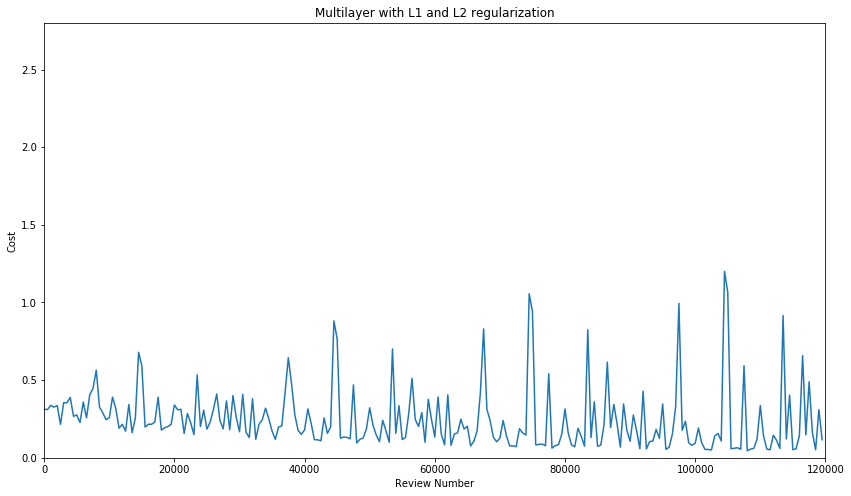

In [56]:
btch1 = 1
loss_t = history['loss_temp']

it     = [i*step for i in range(len(loss_t))]

fig, ax = plt.subplots(figsize=(14, 8))
lt      = ax.plot(it, loss_t)
ax.set(xlabel='Review Number', ylabel='Cost', title='Multilayer with L1 and L2 regularization')
ax.axis([0, len(loss_t)*step  + 0.5, 0.0, 2.8])
#plt.legend([lt],["Training"])
plt.show()

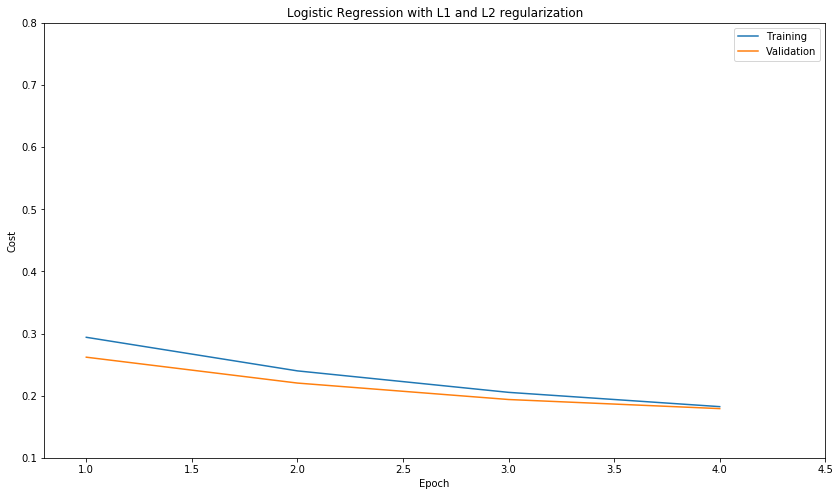

In [62]:
ep = np.arange(1, its + 1, 1)

train_epoch = history['loss_epoch']
valid_epoch = history['loss_valid']
fig, ax = plt.subplots(figsize=(14, 8))
l1 , l2   = ax.plot(ep, train_epoch, ep, valid_epoch)
ax.set(xlabel='Epoch', ylabel='Cost', title='Logistic Regression with L1 and L2 regularization')
ax.axis([0.8, its + 0.5, 0.1, 0.8])
plt.legend([l1, l2],["Training","Validation"])
plt.show()

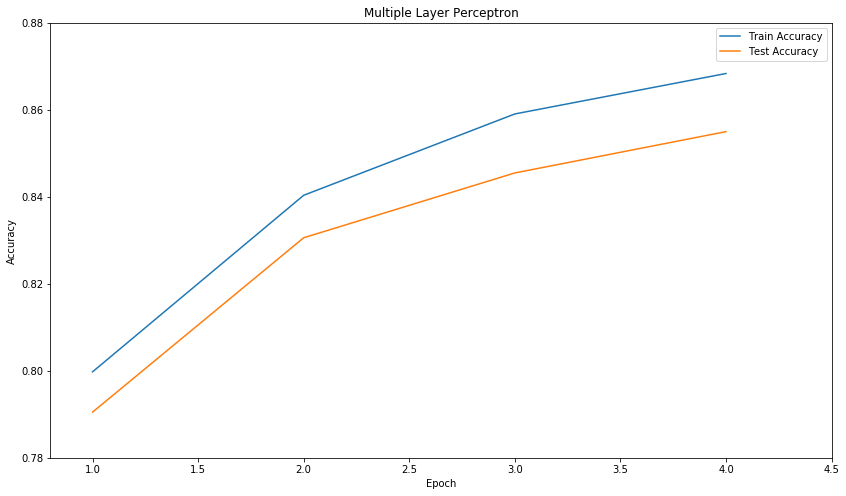

In [70]:
fig, ax = plt.subplots(figsize=(14, 8))

acc_train_epoch = history['acc_train']
acc_test_epoch  = history['acc_test']

l3, l4  = ax.plot(ep, acc_train_epoch, ep, acc_test_epoch)
ax.set(xlabel='Epoch', ylabel='Accuracy', title='Multiple Layer Perceptron')
ax.axis([0.8, its + 0.5, 0.78, 0.88])
plt.legend([l3, l4],["Train Accuracy", "Test Accuracy"])
plt.show()

# Testing

In the previous section, we successfully trained a model to predict the sentiment of a movie review. Unfortunately, if we'd close this IPython notebook at this point, we'd have to go through the whole learning process again and again if we'd want to make a prediction on "new data."

So, to reuse this model, we could use the [`pickle`](https://docs.python.org/3.5/library/pickle.html) module to "serialize a Python object structure". Or even better, we could use the [`joblib`](https://pypi.python.org/pypi/joblib) library, which handles large NumPy arrays more efficiently.

To install:
conda install -c anaconda joblib

In [ ]:
#Exercise 3: compare  with your Neural Network

import joblib
import os
#if not os.path.exists('./pkl_objects'):
#    os.mkdir('./pkl_objects')
    
joblib.dump(encoder, './encoder.pkl')
joblib.dump(net,'./net.pkl')

Now, let us restart this IPython notebook and check if the we can load our serialized objects:

In [101]:
vectorizer = joblib.load('./encoder.pkl')
model      = joblib.load('./net.pkl')

After loading the `tokenizer`, `HashingVectorizer`, and the tranined logistic regression model, we can use it to make predictions on new data, which can be useful, for example, if we'd want to embed our classifier into a web application -- a topic for another IPython notebook.

True : Good comment

False: Bad comment

In [102]:
example = ['I loved this movie']
X = vectorizer.transform(example)

model.predSentiment(X)

array([[ True]])

In [103]:
example = ['This movie was great!']
X = vectorizer.transform(example)

model.predSentiment(X)

array([[ True]])

In [104]:
example = ["I didn't like this movie"]
X = vectorizer.transform(example)

model.predSentiment(X)

array([[False]])

In [105]:
example = ['I did not like this movie']
X = vectorizer.transform(example)

model.predSentiment(X)

array([[False]])

In [106]:
example = ["I don't this movie"]
X = vectorizer.transform(example)

model.predSentiment(X)

array([[False]])